Iteration: 0, Loss: 1709657344.0
Iteration: 50, Loss: 799791872.0
Iteration: 100, Loss: 761250752.0
Iteration: 150, Loss: 741138240.0
Iteration: 200, Loss: 728905216.0
Iteration: 250, Loss: 720776128.0
Iteration: 300, Loss: 715243776.0
Iteration: 350, Loss: 711327616.0
Iteration: 400, Loss: 708575680.0
Iteration: 450, Loss: 706586496.0


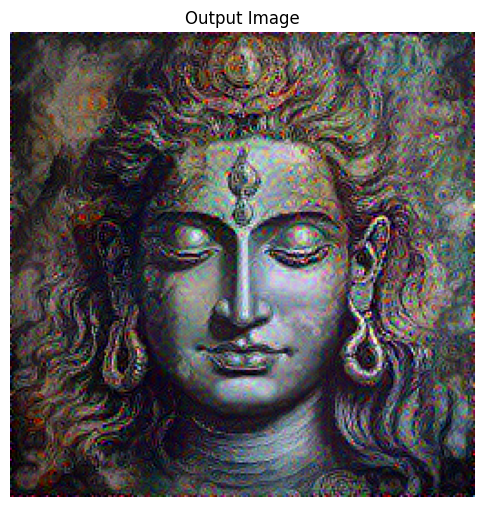

In [ ]:
  import tensorflow as tf
  from tensorflow.keras.applications import VGG19
  from tensorflow.keras.preprocessing.image import load_img, img_to_array
  from tensorflow.keras.models import Model
  import numpy as np
  import matplotlib.pyplot as plt

  # Function to load and preprocess image
  def load_and_process_image(image_path, target_size=(256, 256)):
      img = load_img(image_path, target_size=target_size)
      img = img_to_array(img)
      img = np.expand_dims(img, axis=0)
      img = tf.keras.applications.vgg19.preprocess_input(img)
      return img

  # Function to deprocess the image
  def deprocess_image(processed_img):
      x = processed_img.copy()
      if len(x.shape) == 4:
          x = np.squeeze(x, 0)
      x[:, :, 0] += 103.939
      x[:, :, 1] += 116.779
      x[:, :, 2] += 123.68
      x = x[:, :, ::-1]
      x = np.clip(x, 0, 255).astype('uint8')
      return x

  # Load images with target size
  content_path = '/content/lord1.jpeg'
  style_path = '/content/snake1.jpg'
  target_size = (256, 256)
  content_image = load_and_process_image(content_path, target_size=target_size)
  style_image = load_and_process_image(style_path, target_size=target_size)

  # Load the VGG19 model and choose the layers to use
  vgg = VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  content_layers = ['block5_conv2']
  style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
  num_content_layers = len(content_layers)
  num_style_layers = len(style_layers)

  def get_model():
      outputs = [vgg.get_layer(name).output for name in (style_layers + content_layers)]
      model = Model([vgg.input], outputs)
      return model

  # Define content loss
  def get_content_loss(base_content, target):
      return tf.reduce_mean(tf.square(base_content - target))

  # Compute gram matrix for style loss
  def gram_matrix(input_tensor):
      channels = int(input_tensor.shape[-1])
      a = tf.reshape(input_tensor, [-1, channels])
      n = tf.shape(a)[0]
      gram = tf.matmul(a, a, transpose_a=True)
      return gram / tf.cast(n, tf.float32)

  # Define style loss
  def get_style_loss(base_style, gram_target):
      height, width, channels = base_style.get_shape().as_list()
      gram_style = gram_matrix(base_style)
      return tf.reduce_mean(tf.square(gram_style - gram_target))

  # Define total loss
  def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
      input_tensor = tf.concat([init_image, content_image, style_image], axis=0)
      outputs = model(input_tensor)

      style_output_features = outputs[:num_style_layers]
      content_output_features = outputs[num_content_layers:]

      style_score = 0
      content_score = 0

      weight_style, weight_content = loss_weights

      for target_style, comb_style in zip(gram_style_features, style_output_features):
          style_score += get_style_loss(comb_style[0], target_style)

      for target_content, comb_content in zip(content_features, content_output_features):
          content_score += get_content_loss(comb_content[0], target_content)

      style_score *= weight_style / num_style_layers
      content_score *= weight_content / num_content_layers

      loss = style_score + content_score
      return loss

  # Extract style and content features
  def get_feature_representations(model, content_image, style_image):
      style_outputs = model(style_image)
      content_outputs = model(content_image)

      style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
      content_features = [content_layer[0] for content_layer in content_outputs[num_content_layers:]]
      return style_features, content_features

  # Compute gradients
  def compute_grads(cfg):
      with tf.GradientTape() as tape:
          all_loss = compute_loss(**cfg)
      total_loss = all_loss
      return tape.gradient(total_loss, cfg['init_image']), all_loss

  # Style transfer function
  def run_style_transfer(content_path, style_path, num_iterations=500, content_weight=1e3, style_weight=1e-2):
      model = get_model()
      for layer in model.layers:
          layer.trainable = False

      content_image = load_and_process_image(content_path, target_size=target_size)
      style_image = load_and_process_image(style_path, target_size=target_size)

      style_features, content_features = get_feature_representations(model, content_image, style_image)
      gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

      init_image = tf.Variable(content_image, dtype=tf.float32)
      opt = tf.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)

      best_loss, best_img = float('inf'), None

      loss_weights = (style_weight, content_weight)
      cfg = {
          'model': model,
          'loss_weights': loss_weights,
          'init_image': init_image,
          'gram_style_features': gram_style_features,
          'content_features': content_features
      }

      norm_means = np.array([103.939, 116.779, 123.68])
      min_vals = -norm_means
      max_vals = 255 - norm_means

      for i in range(num_iterations):
          grads, all_loss = compute_grads(cfg)
          loss = all_loss
          opt.apply_gradients([(grads, init_image)])
          clipped = tf.clip_by_value(init_image, min_vals, max_vals)
          init_image.assign(clipped)

          if loss < best_loss:
              best_loss = loss
              best_img = deprocess_image(init_image.numpy())

          if i % 50 == 0:
              print(f"Iteration: {i}, Loss: {loss}")

      return best_img, best_loss

  # Run style transfer
  best_img, best_loss = run_style_transfer(content_path, style_path)

  # Display the result
  plt.figure(figsize=(6, 8))
  plt.imshow(best_img)
  plt.title('Output Image')
  plt.axis('off')
  plt.show()


Iteration: 0, Loss: 1709657344.0
Iteration: 50, Loss: 799808832.0
Iteration: 100, Loss: 761259264.0
Iteration: 150, Loss: 741119232.0
Iteration: 200, Loss: 728940992.0
Iteration: 250, Loss: 720693504.0
Iteration: 300, Loss: 715148800.0
Iteration: 350, Loss: 711216000.0
Iteration: 400, Loss: 708440384.0
Iteration: 450, Loss: 706453824.0


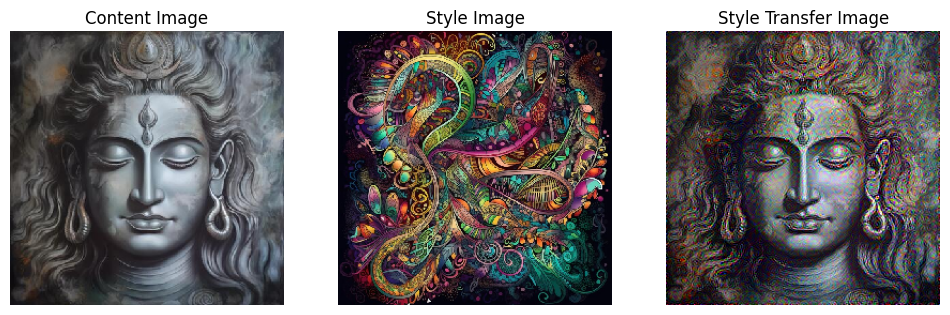

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# Function to load and preprocess image
def load_and_process_image(image_path, target_size=(256, 256)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

# Function to deprocess the image
def deprocess_image(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# Load images with target size
content_path = '/content/lord1.jpeg'
style_path = '/content/snake1.jpg'
target_size = (256, 256)
content_image = load_and_process_image(content_path, target_size=target_size)
style_image = load_and_process_image(style_path, target_size=target_size)

# Load the VGG19 model and choose the layers to use
vgg = VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

def get_model():
    outputs = [vgg.get_layer(name).output for name in (style_layers + content_layers)]
    model = Model([vgg.input], outputs)
    return model

# Define content loss
def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

# Compute gram matrix for style loss
def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

# Define style loss
def get_style_loss(base_style, gram_target):
    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)
    return tf.reduce_mean(tf.square(gram_style - gram_target))

# Define total loss
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    input_tensor = tf.concat([init_image, content_image, style_image], axis=0)
    outputs = model(input_tensor)

    style_output_features = outputs[:num_style_layers]
    content_output_features = outputs[num_content_layers:]

    style_score = 0
    content_score = 0

    weight_style, weight_content = loss_weights

    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += get_style_loss(comb_style[0], target_style)

    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += get_content_loss(comb_content[0], target_content)

    style_score *= weight_style / num_style_layers
    content_score *= weight_content / num_content_layers

    loss = style_score + content_score
    return loss

# Extract style and content features
def get_feature_representations(model, content_image, style_image):
    style_outputs = model(style_image)
    content_outputs = model(content_image)

    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer[0] for content_layer in content_outputs[num_content_layers:]]
    return style_features, content_features

# Compute gradients
def compute_grads(cfg):
    with tf.GradientTape() as tape:
        all_loss = compute_loss(**cfg)
    total_loss = all_loss
    return tape.gradient(total_loss, cfg['init_image']), all_loss

# Style transfer function
def run_style_transfer(content_path, style_path, num_iterations=500, content_weight=1e3, style_weight=1e-2):
    model = get_model()
    for layer in model.layers:
        layer.trainable = False

    content_image = load_and_process_image(content_path, target_size=target_size)
    style_image = load_and_process_image(style_path, target_size=target_size)

    style_features, content_features = get_feature_representations(model, content_image, style_image)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

    init_image = tf.Variable(content_image, dtype=tf.float32)
    opt = tf.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)

    best_loss, best_img = float('inf'), None

    loss_weights = (style_weight, content_weight)
    cfg = {
        'model': model,
        'loss_weights': loss_weights,
        'init_image': init_image,
        'gram_style_features': gram_style_features,
        'content_features': content_features
    }

    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means

    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        loss = all_loss
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)

        if loss < best_loss:
            best_loss = loss
            best_img = deprocess_image(init_image.numpy())

        if i % 50 == 0:
            print(f"Iteration: {i}, Loss: {loss}")

    return best_img, best_loss

# Run style transfer
best_img, best_loss = run_style_transfer(content_path, style_path)

# Deprocess the content and style images for display
content_image_deprocessed = deprocess_image(content_image)
style_image_deprocessed = deprocess_image(style_image)

# Display the images
plt.figure(figsize=(12, 12))

plt.subplot(1, 3, 1)
plt.imshow(content_image_deprocessed)
plt.title('Content Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(style_image_deprocessed)
plt.title('Style Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(best_img)
plt.title('Style Transfer Image')
plt.axis('off')

plt.show()


Iteration: 0, Loss: 3482814976.0
Iteration: 50, Loss: 1301763328.0
Iteration: 100, Loss: 1214585088.0
Iteration: 150, Loss: 1170296704.0
Iteration: 200, Loss: 1144418048.0
Iteration: 250, Loss: 1127100032.0
Iteration: 300, Loss: 1115082752.0
Iteration: 350, Loss: 1106206592.0
Iteration: 400, Loss: 1099965696.0
Iteration: 450, Loss: 1095283072.0


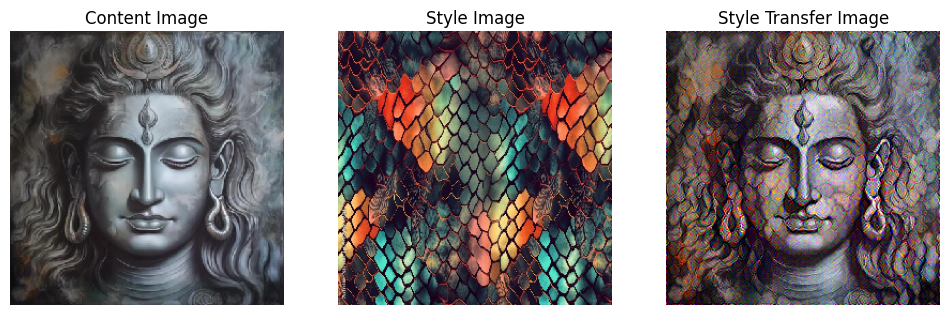

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# Function to load and preprocess image
def load_and_process_image(image_path, target_size=(256, 256)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

# Function to deprocess the image
def deprocess_image(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# Load images with target size
content_path = '/content/lord1.jpeg'
style_path = '/content/snake1.jpg'
target_size = (256, 256)
content_image = load_and_process_image(content_path, target_size=target_size)
style_image = load_and_process_image(style_path, target_size=target_size)

# Load the VGG19 model and choose the layers to use
vgg = VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

def get_model():
    outputs = [vgg.get_layer(name).output for name in (style_layers + content_layers)]
    model = Model([vgg.input], outputs)
    return model

# Define content loss
def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

# Compute gram matrix for style loss
def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

# Define style loss
def get_style_loss(base_style, gram_target):
    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)
    return tf.reduce_mean(tf.square(gram_style - gram_target))

# Define total loss
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    input_tensor = tf.concat([init_image, content_image, style_image], axis=0)
    outputs = model(input_tensor)

    style_output_features = outputs[:num_style_layers]
    content_output_features = outputs[num_content_layers:]

    style_score = 0
    content_score = 0

    weight_style, weight_content = loss_weights

    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += get_style_loss(comb_style[0], target_style)

    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += get_content_loss(comb_content[0], target_content)

    style_score *= weight_style / num_style_layers
    content_score *= weight_content / num_content_layers

    loss = style_score + content_score
    return loss

# Extract style and content features
def get_feature_representations(model, content_image, style_image):
    style_outputs = model(style_image)
    content_outputs = model(content_image)

    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer[0] for content_layer in content_outputs[num_content_layers:]]
    return style_features, content_features

# Compute gradients
def compute_grads(cfg):
    with tf.GradientTape() as tape:
        all_loss = compute_loss(**cfg)
    total_loss = all_loss
    return tape.gradient(total_loss, cfg['init_image']), all_loss

# Style transfer function
def run_style_transfer(content_path, style_path, num_iterations=500, content_weight=1e3, style_weight=1e-2):
    model = get_model()
    for layer in model.layers:
        layer.trainable = False

    content_image = load_and_process_image(content_path, target_size=target_size)
    style_image = load_and_process_image(style_path, target_size=target_size)

    style_features, content_features = get_feature_representations(model, content_image, style_image)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

    init_image = tf.Variable(content_image, dtype=tf.float32)
    opt = tf.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)

    best_loss, best_img = float('inf'), None

    loss_weights = (style_weight, content_weight)
    cfg = {
        'model': model,
        'loss_weights': loss_weights,
        'init_image': init_image,
        'gram_style_features': gram_style_features,
        'content_features': content_features
    }

    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means

    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        loss = all_loss
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)

        if loss < best_loss:
            best_loss = loss
            best_img = deprocess_image(init_image.numpy())

        if i % 50 == 0:
            print(f"Iteration: {i}, Loss: {loss}")

    return best_img, best_loss

# Run style transfer
best_img, best_loss = run_style_transfer(content_path, style_path)

# Deprocess the content and style images for display
content_image_deprocessed = deprocess_image(content_image)
style_image_deprocessed = deprocess_image(style_image)

# Display the images
plt.figure(figsize=(12, 12))

plt.subplot(1, 3, 1)
plt.imshow(content_image_deprocessed)
plt.title('Content Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(style_image_deprocessed)
plt.title('Style Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(best_img)
plt.title('Style Transfer Image')
plt.axis('off')

plt.show()
